#**Setup**



In [122]:
#mount to googledrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [123]:
!pip install datasets

In [124]:
!pip install transformers[torch]

In [125]:
!pip install accelerate -U

In [126]:
!pip install transformers

In [127]:
!pip install tensorboard

In [128]:
from datasets import load_dataset, load_metric, ClassLabel
from transformers import AutoTokenizer
from transformers import AutoModelForMultipleChoice, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score
from dataclasses import dataclass
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from typing import Optional, Union
import matplotlib.pyplot as plt
import transformers
import random
import pandas as pd
from pprint import pprint
import torch
import math
import time
import sys
import json
import numpy as np

#**Dataset path and Model**

In [129]:
#file path
root = '/content/drive/My Drive/Swinburne/TIP/data3/'

In [130]:
model_checkpoint = "ALBERT-base-v2"
model = AutoModelForMultipleChoice.from_pretrained(model_checkpoint)

Some weights of AlbertForMultipleChoice were not initialized from the model checkpoint at ALBERT-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#**Tokenizer**

In [131]:
#import tokenizer

tokenizer  = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

In [132]:
tokenizer("Hello, this is a sentence!", "Pray for us to finish this project!", "Go with these sentences!")

{'input_ids': [2, 10975, 15, 48, 25, 21, 5123, 187, 3, 12181, 26, 182, 20, 2106, 48, 669, 187, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [2, 162, 29, 158, 13453, 187, 3]}

# **Train, Evaluation dataset**

In [133]:
#import training dataset
#train_df = pd.read_csv(root + 'fixed_SciQ.csv')
train_df = pd.read_csv(root + 'train_new_q360-4-with-choice.csv')
train_df.head()

,id,prompt,A,B,C,D,answer
0,1,EIA IS STUDY OF PROBABLE CHANGE IN SOCIO ECONO...,A. BIOPHYSICAL,B. GEOLOGICAL,C. HYDROLOGICAL,D. POTENTIAL,A
1,2,EIA IS __ AND __ ENVIRONMENTAL IMPACTS.,A. BENEFICIAL AND ADVERSE,B. SOCIAL AND BENEFIT,C. ADVERSE AND ECONOMICAL,D. NONE OF ABOVE,A
2,3,"___ IS EVIDENT THAT ORDER TO IDENTIFY, ASSESS ...",A. ENVIRONMENTAL ATTRIBUTES,B. ENVIRONMENTAL IMPACT,C. COMPLEX SYSTEM,D. VARIABLE PARAMETER,A
3,4,"EIA IS INCLUDING MECHANISMS FOR MONITORING, AN...",A. SPECIFICATION,B. AUDITING,C. REPORTING,D. CONCLUDING,B
4,5,EIA IS STUDY TO DELINEATE BETWEEN BENEFICIAL A...,A. MICRO,B. ACTION,C. PROPOSED,D. MACRO,D


In [134]:
train_df.shape

(361, 7)

In [135]:
train_df['answer'].value_counts()

A    107
C     95
B     94
D     65
Name: answer, dtype: int64

In [136]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset

#Randomly sample 5000 rows from the original data.
#sampled_train_df = train_df.sample(n=5000, random_state=42)

# Split data into training and evaluation sets
#train_df, eval_df = train_test_split(sampled_train_df, test_size=0.2, random_state=42)


train_df, eval_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [137]:
# transform pandas Dataframe into a Dataset
train_ds = Dataset.from_pandas(train_df)
eval_ds = Dataset.from_pandas(eval_df)

In [138]:
train_ds.shape

(288, 8)

In [139]:
answer_series = pd.Series(train_ds['answer'])
answer_series.value_counts()

A    86
C    77
B    71
D    54
dtype: int64

In [140]:
eval_ds.shape

(73, 8)

# **Data preparation**

In [141]:
# create a dictionary to convert option names (A, B, C, D) into indices and back again

options = 'ABCD'
indices = list(range(4))

option_to_index = {option: index for option, index in zip(options, indices)}
index_to_option = {index: option for option, index in zip(options, indices)}

def preprocess(example):
    # the AutoModelForMultipleChoice class expects a set of question/answer pairs
    # each replicated question is then paired with one of the answer choices for tokenization
    first_sentence = [example['prompt']] * 4      #question
    second_sentence = [example[option] for option in options]  #option

    # the tokenizer will turn the text into token IDs that model BERT can understand
    # including truncation, padding, and max_length for consistent sequence length
    tokenized_example = tokenizer(
        first_sentence,
        second_sentence,
        truncation=True, # allow tokenizer to cut down the question if it is longer than max_length
        padding='max_length',  # pad to max_length
        max_length=512  # max length of Bert
    )

    # convert the categorical answer label to a numerical index using the predefined
    tokenized_example['label'] = option_to_index[example['answer']]

    return tokenized_example


tokenized_train_ds = train_ds.map(preprocess, batched=False, remove_columns=['prompt', 'A', 'B', 'C', 'D', 'answer'])
tokenized_eval_ds = eval_ds.map(preprocess, batched=False, remove_columns=['prompt', 'A', 'B', 'C', 'D', 'answer'])

Map:   0%|          | 0/288 [00:00<?, ? examples/s]

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

In [142]:
print(tokenized_train_ds[0])
print(tokenized_eval_ds[0])

{'id': 210, '__index_level_0__': 209, 'input_ids': [[2, 56, 718, 16, 3549, 950, 24480, 18, 25, 1864, 26, 4721, 21, 12642, 54, 6453, 93, 3576, 20, 950, 1985, 60, 3, 21, 9, 3579, 1287, 18, 16292, 18, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [143]:
# Following datacollator (adapted from https://huggingface.co/docs/transformers/tasks/multiple_choice)
# dynamically pad the sentences to the longest length in a batch during collation,
# instead of padding the whole dataset to the maximum length.
# takes a batch of multiple-choice data, flattens it to apply consistent padding across all sequences,
# and then reshapes it into the format expected by a multiple-choice transformer model
from dataclasses import dataclass
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from typing import Optional, Union
import torch

@dataclass
class DataCollatorForMultipleChoice:
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None

    def __call__(self, features):
        label_name = "label" if 'label' in features[0].keys() else 'labels'
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]['input_ids'])
        flattened_features = [
            [{k: v[i] for k, v in feature.items()} for i in range(num_choices)] for feature in features
        ]
        flattened_features = sum(flattened_features, [])

        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors='pt',
        )
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        batch['labels'] = torch.tensor(labels, dtype=torch.int64)
        return batch

#**Accuracy metric**

In [144]:
# accuracy metric

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # for multiple choice, select the answer with the highest score
    predictions = predictions.argmax(axis=1)
    return {'accuracy': accuracy_score(labels, predictions)}

# **Model saving directory**

In [145]:
import os
from datetime import datetime
import pytz
my_timezone = pytz.timezone("Australia/Melbourne")  # Replace with your time zone

# get the current date and time
now = datetime.now(my_timezone)
timestamp = now.strftime("%d%m%Y_%H%M%S")

# define the model directory
root_model_dir = "/content/drive/My Drive/Swinburne/TIP/model/05102023_new_model/my_model_chkpt"
model_dir_name = f"finetuned_bert_{timestamp}"
model_dir = os.path.join(root_model_dir, model_dir_name)


In [146]:
print("Model directory:"+ model_dir)
print("logs directory:" + os.path.join(model_dir, f'logs_{timestamp}'))

Model directory:/content/drive/My Drive/Swinburne/TIP/model/05102023_new_model/my_model_chkpt/finetuned_bert_15102023_170823
logs directory:/content/drive/My Drive/Swinburne/TIP/model/05102023_new_model/my_model_chkpt/finetuned_bert_15102023_170823/logs_15102023_170823


# **Model Training**

In [147]:
training_args = TrainingArguments(
    output_dir=model_dir,
    evaluation_strategy="epoch",  # evaluate at the end of each epoch
    logging_dir=os.path.join(model_dir, f'logs_{timestamp}'),  # logs are saved as los_timestamp, p.s. we dont use this file to plot graphs
    save_strategy="epoch",  # save at the end of each epoch
    load_best_model_at_end=True,
    learning_rate=3e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    report_to='tensorboard',  # report metrics to TensorBoard
)


In [148]:
# initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_eval_ds,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

In [149]:
# train and save model
trainer.train()
trainer.save_model(model_dir)

# evaluate the model
metrics = trainer.evaluate()

# access and print the accuracy
print(f"Accuracy: {metrics['eval_accuracy']:.2f}")


You're using a AlbertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.385817,0.287671
2,No log,1.386535,0.164384
3,No log,1.385552,0.424658
4,No log,1.385954,0.383562
5,No log,1.385765,0.287671


Accuracy: 0.42


In [150]:
# after training, find the latest checkpoint directory
all_subdirs = [d for d in os.listdir(model_dir) if os.path.isdir(os.path.join(model_dir, d))]
checkpoint_dirs = [d for d in all_subdirs if d.startswith("checkpoint-")]
latest_checkpoint_dir = max(checkpoint_dirs, key=lambda d: int(d.split("-")[1]))

print(latest_checkpoint_dir)

checkpoint-360


In [151]:
# define the log file path which will be extracted logs
log_dir = os.path.join(model_dir, latest_checkpoint_dir)
log_file = os.path.join(log_dir, 'trainer_state.json')

#model call back
#log_dir = "/content/drive/My Drive/Swinburne/TIP/model/05102023_new_model/my_model_chkpt/finetuned_bert_20231006_031400/checkpoint-80/"
#log_file = log_dir+'trainer_state.json'

In [152]:

try:
    with open(log_file, 'r') as f:
        logs = json.load(f)

    log_history = logs['log_history']


    eval_log_history = []
    for epoch in [1.0, 2.0, 3.0, 4.0,5.0,6.0,7.0,8.0,]:
        for log in log_history:
            if log['epoch'] == epoch and 'eval_accuracy' in log:
                eval_log_history.append(log)
                break

    # Convert filtered log history to DataFrame
    df = pd.DataFrame(eval_log_history)

    # Print the DataFrame
    print(df)

except FileNotFoundError:
    print(f"No log file found at: {log_file}")
except KeyError as e:
    print(f"KeyError: {str(e)}. Available keys: {', '.join(logs['log_history'][0].keys())}")


   epoch  eval_accuracy  eval_loss  eval_runtime  eval_samples_per_second  \
0    1.0       0.287671   1.385817       10.0601                    7.256   
1    2.0       0.164384   1.386535       10.2944                    7.091   
2    3.0       0.424658   1.385552       10.2968                    7.090   
3    4.0       0.383562   1.385954       10.3672                    7.041   
4    5.0       0.287671   1.385765       10.3833                    7.031   

   eval_steps_per_second  step  
0                  1.889    72  
1                  1.846   144  
2                  1.845   216  
3                  1.833   288  
4                  1.830   360  


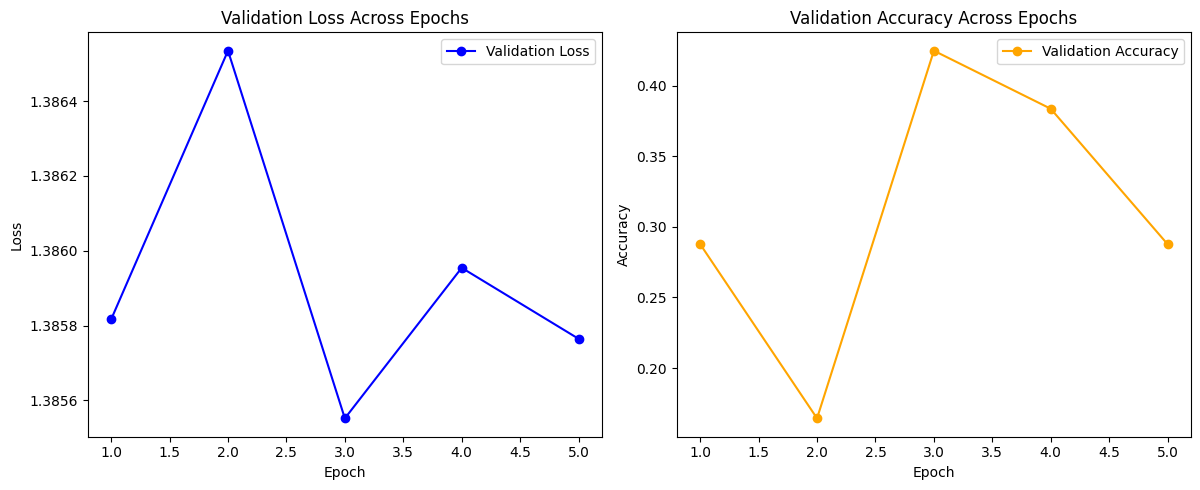

In [153]:
import matplotlib.pyplot as plt

# plotting
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(df['epoch'], df['eval_loss'], label='Validation Loss', marker='o', linestyle='-', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Across Epochs')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(df['epoch'], df['eval_accuracy'], label='Validation Accuracy', marker='o', linestyle='-', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Across Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [154]:
print(log_history)

[{'epoch': 1.0, 'eval_accuracy': 0.2876712328767123, 'eval_loss': 1.3858165740966797, 'eval_runtime': 10.0601, 'eval_samples_per_second': 7.256, 'eval_steps_per_second': 1.889, 'step': 72}, {'epoch': 2.0, 'eval_accuracy': 0.1643835616438356, 'eval_loss': 1.3865346908569336, 'eval_runtime': 10.2944, 'eval_samples_per_second': 7.091, 'eval_steps_per_second': 1.846, 'step': 144}, {'epoch': 3.0, 'eval_accuracy': 0.4246575342465753, 'eval_loss': 1.3855520486831665, 'eval_runtime': 10.2968, 'eval_samples_per_second': 7.09, 'eval_steps_per_second': 1.845, 'step': 216}, {'epoch': 4.0, 'eval_accuracy': 0.3835616438356164, 'eval_loss': 1.3859543800354004, 'eval_runtime': 10.3672, 'eval_samples_per_second': 7.041, 'eval_steps_per_second': 1.833, 'step': 288}, {'epoch': 5.0, 'eval_accuracy': 0.2876712328767123, 'eval_loss': 1.385764718055725, 'eval_runtime': 10.3833, 'eval_samples_per_second': 7.031, 'eval_steps_per_second': 1.83, 'step': 360}]


#**Prediction on training dataset**

In [155]:
# make predictions on our questions
predictions = trainer.predict(tokenized_train_ds)

In [156]:
# gets the indices of the highest scoring answers for each row
# and converts them back to answer format (A, B, C, D)
import numpy as np
def predictions_to_map_output(predictions):
    sorted_answer_indices = np.argsort(-predictions)
    top_answer_indices = sorted_answer_indices[:,:3] # get the first three answers in each row
    top_answers = np.vectorize(index_to_option.get)(top_answer_indices)
    return np.apply_along_axis(lambda row: ' '.join(row), 1, top_answers)

In [157]:
# double check the output
predictions_to_map_output(predictions.predictions)

array(['A C B', 'C B A', 'C B D', 'C B A', 'A D B', 'B D C', 'A B D',
       'C D A', 'D A C', 'B A C', 'A B C', 'A B C', 'A B C', 'A B C',
       'A D C', 'C B A', 'C B A', 'D B A', 'C A D', 'C D A', 'B D A',
       'B A D', 'A D C', 'B A C', 'B A C', 'A B D', 'A B C', 'C B A',
       'D B A', 'A B C', 'C B A', 'C B D', 'D B A', 'C D A', 'C B A',
       'A C D', 'A D C', 'C B D', 'A D C', 'A B C', 'C B D', 'B D A',
       'B A C', 'C D A', 'C B D', 'C B A', 'B A C', 'B D A', 'C A B',
       'B C A', 'B A C', 'A C B', 'B A D', 'B C A', 'B C A', 'A C B',
       'D C B', 'B A C', 'C A D', 'C A B', 'A C B', 'C B A', 'C B A',
       'A B C', 'C B A', 'A B C', 'B A C', 'C A B', 'B D A', 'B A C',
       'A B C', 'B C A', 'B A C', 'C A D', 'D C B', 'B D C', 'D B A',
       'C B A', 'C D B', 'C B A', 'A C B', 'C A B', 'C A B', 'A C B',
       'B A C', 'B A C', 'C B A', 'A D B', 'D C B', 'B C D', 'C A B',
       'A B C', 'B A C', 'B C A', 'A C D', 'B C A', 'B C D', 'C B A',
       'C B A', 'A C

#**Model Testing**

In [158]:
# load the test dataset to the mode;

test_df = pd.read_csv(root + 'new_q360-4-with-choice.csv')

#test_df = pd.read_csv(root + '360questions.csv')
test_df.head()

,id,prompt,A,B,C,D,answer,multiple_answer,answer_count
0,1,EIA IS STUDY OF PROBABLE CHANGE IN SOCIO ECONO...,A. BIOPHYSICAL,B. GEOLOGICAL,C. HYDROLOGICAL,D. POTENTIAL,A,A,1
1,2,EIA IS __ AND __ ENVIRONMENTAL IMPACTS.,A. BENEFICIAL AND ADVERSE,B. SOCIAL AND BENEFIT,C. ADVERSE AND ECONOMICAL,D. NONE OF ABOVE,A,A,1
2,3,"___ IS EVIDENT THAT ORDER TO IDENTIFY, ASSESS ...",A. ENVIRONMENTAL ATTRIBUTES,B. ENVIRONMENTAL IMPACT,C. COMPLEX SYSTEM,D. VARIABLE PARAMETER,A,A,1
3,4,"EIA IS INCLUDING MECHANISMS FOR MONITORING, AN...",A. SPECIFICATION,B. AUDITING,C. REPORTING,D. CONCLUDING,B,B,1
4,5,EIA IS STUDY TO DELINEATE BETWEEN BENEFICIAL A...,A. MICRO,B. ACTION,C. PROPOSED,D. MACRO,D,D,1


In [159]:
test_df.shape

(361, 9)

In [160]:
test_df['multiple_answer'].value_counts()

C      92
A      89
B      87
D      65
AC      6
AB      5
BC      5
CD      4
AD      3
ABC     2
BD      1
ABD     1
BCD     1
Name: multiple_answer, dtype: int64

In [161]:
# check for missing values in relevant columns
columns_to_check = ['prompt', 'A', 'B', 'C', 'D', 'answer','multiple_answer','answer_count']
print(test_df[columns_to_check].isnull().sum())


prompt             0
A                  0
B                  0
C                  0
D                  0
answer             0
multiple_answer    0
answer_count       0
dtype: int64


In [162]:
test_df[columns_to_check] = test_df[columns_to_check].fillna("MISSING")

In [163]:
# convert relevant columns to string type
test_df[columns_to_check] = test_df[columns_to_check].astype(str)


In [164]:
test_df.head()

,id,prompt,A,B,C,D,answer,multiple_answer,answer_count
0,1,EIA IS STUDY OF PROBABLE CHANGE IN SOCIO ECONO...,A. BIOPHYSICAL,B. GEOLOGICAL,C. HYDROLOGICAL,D. POTENTIAL,A,A,1
1,2,EIA IS __ AND __ ENVIRONMENTAL IMPACTS.,A. BENEFICIAL AND ADVERSE,B. SOCIAL AND BENEFIT,C. ADVERSE AND ECONOMICAL,D. NONE OF ABOVE,A,A,1
2,3,"___ IS EVIDENT THAT ORDER TO IDENTIFY, ASSESS ...",A. ENVIRONMENTAL ATTRIBUTES,B. ENVIRONMENTAL IMPACT,C. COMPLEX SYSTEM,D. VARIABLE PARAMETER,A,A,1
3,4,"EIA IS INCLUDING MECHANISMS FOR MONITORING, AN...",A. SPECIFICATION,B. AUDITING,C. REPORTING,D. CONCLUDING,B,B,1
4,5,EIA IS STUDY TO DELINEATE BETWEEN BENEFICIAL A...,A. MICRO,B. ACTION,C. PROPOSED,D. MACRO,D,D,1


In [165]:
test_ds = Dataset.from_pandas(test_df)

In [166]:
tokenized_test_ds = test_ds.map(preprocess, batched=False, remove_columns=['prompt', 'A', 'B', 'C', 'D', 'answer','multiple_answer','answer_count'])

Map:   0%|          | 0/361 [00:00<?, ? examples/s]

In [167]:
# generate the predictions on the test dataset
test_predictions = trainer.predict(tokenized_test_ds)

In [168]:
test_predictions

PredictionOutput(predictions=array([[-0.13021685, -0.13083838, -0.1309496 , -0.13243254],
       [-0.14216352, -0.14103492, -0.14214297, -0.14259769],
       [-0.12961425, -0.1271215 , -0.1295835 , -0.13414825],
       ...,
       [-0.12871794, -0.13429199, -0.13235073, -0.13067542],
       [-0.13143061, -0.13038331, -0.13070412, -0.13180356],
       [-0.12849404, -0.12591967, -0.12900971, -0.13082148]],
      dtype=float32), label_ids=array([0, 0, 0, 1, 3, 0, 2, 1, 1, 2, 2, 3, 0, 2, 2, 0, 0, 3, 0, 2, 3, 0,
       0, 0, 0, 1, 0, 0, 0, 3, 1, 2, 1, 3, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0,
       2, 3, 1, 1, 2, 1, 3, 1, 1, 0, 2, 0, 3, 0, 0, 2, 2, 0, 0, 0, 1, 0,
       1, 0, 3, 2, 0, 2, 1, 2, 2, 0, 1, 1, 2, 1, 2, 0, 2, 1, 0, 0, 3, 0,
       2, 0, 1, 1, 3, 1, 3, 2, 2, 0, 2, 0, 3, 2, 2, 0, 0, 1, 0, 0, 0, 0,
       3, 0, 0, 2, 0, 1, 0, 0, 2, 0, 2, 0, 3, 0, 2, 0, 3, 0, 0, 1, 2, 1,
       1, 3, 0, 2, 3, 0, 3, 3, 2, 0, 1, 1, 3, 2, 1, 3, 0, 1, 3, 0, 2, 0,
       0, 2, 1, 1, 1, 1, 3, 0, 0, 1, 1, 0, 1, 3, 

In [169]:
# create submission file using the id column from test.csv which contain the prediction answers
submission_df = test_df[['id']]
submission_df['all_answer_prediction'] = predictions_to_map_output(test_predictions.predictions)


<ipython-input-169-c5e756141724>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission_df['all_answer_prediction'] = predictions_to_map_output(test_predictions.predictions)


In [170]:
submission_df.head(10)

,id,all_answer_prediction
0,1,A B C
1,2,B C A
2,3,B C A
3,4,B C D
4,5,B C A
5,6,D B C
6,7,C B A
7,8,B A C
8,9,C B A
9,10,B C A


In [171]:
from sklearn.metrics import accuracy_score

# ensure the answers are in the same order for comparison
final_df = pd.merge(submission_df, test_df, on='id', how='inner')
final_df.head()

,id,all_answer_prediction,prompt,A,B,C,D,answer,multiple_answer,answer_count
0,1,A B C,EIA IS STUDY OF PROBABLE CHANGE IN SOCIO ECONO...,A. BIOPHYSICAL,B. GEOLOGICAL,C. HYDROLOGICAL,D. POTENTIAL,A,A,1
1,2,B C A,EIA IS __ AND __ ENVIRONMENTAL IMPACTS.,A. BENEFICIAL AND ADVERSE,B. SOCIAL AND BENEFIT,C. ADVERSE AND ECONOMICAL,D. NONE OF ABOVE,A,A,1
2,3,B C A,"___ IS EVIDENT THAT ORDER TO IDENTIFY, ASSESS ...",A. ENVIRONMENTAL ATTRIBUTES,B. ENVIRONMENTAL IMPACT,C. COMPLEX SYSTEM,D. VARIABLE PARAMETER,A,A,1
3,4,B C D,"EIA IS INCLUDING MECHANISMS FOR MONITORING, AN...",A. SPECIFICATION,B. AUDITING,C. REPORTING,D. CONCLUDING,B,B,1
4,5,B C A,EIA IS STUDY TO DELINEATE BETWEEN BENEFICIAL A...,A. MICRO,B. ACTION,C. PROPOSED,D. MACRO,D,D,1


In [172]:
# Ensure 'answer_count' is of integer type
final_df['answer_count'] = final_df['answer_count'].astype(int)

final_df['all_answer_prediction'] = final_df['all_answer_prediction'].str.replace(' ', '')

In [173]:
final_df.head()

,id,all_answer_prediction,prompt,A,B,C,D,answer,multiple_answer,answer_count
0,1,ABC,EIA IS STUDY OF PROBABLE CHANGE IN SOCIO ECONO...,A. BIOPHYSICAL,B. GEOLOGICAL,C. HYDROLOGICAL,D. POTENTIAL,A,A,1
1,2,BCA,EIA IS __ AND __ ENVIRONMENTAL IMPACTS.,A. BENEFICIAL AND ADVERSE,B. SOCIAL AND BENEFIT,C. ADVERSE AND ECONOMICAL,D. NONE OF ABOVE,A,A,1
2,3,BCA,"___ IS EVIDENT THAT ORDER TO IDENTIFY, ASSESS ...",A. ENVIRONMENTAL ATTRIBUTES,B. ENVIRONMENTAL IMPACT,C. COMPLEX SYSTEM,D. VARIABLE PARAMETER,A,A,1
3,4,BCD,"EIA IS INCLUDING MECHANISMS FOR MONITORING, AN...",A. SPECIFICATION,B. AUDITING,C. REPORTING,D. CONCLUDING,B,B,1
4,5,BCA,EIA IS STUDY TO DELINEATE BETWEEN BENEFICIAL A...,A. MICRO,B. ACTION,C. PROPOSED,D. MACRO,D,D,1


In [174]:
print(final_df['answer_count'].dtype)

int64


In [175]:
def extract_chars(row):
    return row['all_answer_prediction'][:row['answer_count']]

In [176]:
final_df['final_answer_prediction'] = final_df.apply(extract_chars, axis=1)


In [177]:
final_df.head()

,id,all_answer_prediction,prompt,A,B,C,D,answer,multiple_answer,answer_count,final_answer_prediction
0,1,ABC,EIA IS STUDY OF PROBABLE CHANGE IN SOCIO ECONO...,A. BIOPHYSICAL,B. GEOLOGICAL,C. HYDROLOGICAL,D. POTENTIAL,A,A,1,A
1,2,BCA,EIA IS __ AND __ ENVIRONMENTAL IMPACTS.,A. BENEFICIAL AND ADVERSE,B. SOCIAL AND BENEFIT,C. ADVERSE AND ECONOMICAL,D. NONE OF ABOVE,A,A,1,B
2,3,BCA,"___ IS EVIDENT THAT ORDER TO IDENTIFY, ASSESS ...",A. ENVIRONMENTAL ATTRIBUTES,B. ENVIRONMENTAL IMPACT,C. COMPLEX SYSTEM,D. VARIABLE PARAMETER,A,A,1,B
3,4,BCD,"EIA IS INCLUDING MECHANISMS FOR MONITORING, AN...",A. SPECIFICATION,B. AUDITING,C. REPORTING,D. CONCLUDING,B,B,1,B
4,5,BCA,EIA IS STUDY TO DELINEATE BETWEEN BENEFICIAL A...,A. MICRO,B. ACTION,C. PROPOSED,D. MACRO,D,D,1,B


In [178]:
final_df["final_answer_prediction"].value_counts()

B      99
A      98
C      98
D      38
BC      6
AB      5
BA      3
BD      2
CB      2
DC      2
AC      1
ADC     1
CD      1
BCA     1
CBA     1
DB      1
AD      1
DCA     1
Name: final_answer_prediction, dtype: int64

In [179]:
# calculate accuracy
accuracy = accuracy_score(final_df['multiple_answer'], final_df['final_answer_prediction'])

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.33


# **Final Output**

In [180]:
final_df.head(10)

,id,all_answer_prediction,prompt,A,B,C,D,answer,multiple_answer,answer_count,final_answer_prediction
0,1,ABC,EIA IS STUDY OF PROBABLE CHANGE IN SOCIO ECONO...,A. BIOPHYSICAL,B. GEOLOGICAL,C. HYDROLOGICAL,D. POTENTIAL,A,A,1,A
1,2,BCA,EIA IS __ AND __ ENVIRONMENTAL IMPACTS.,A. BENEFICIAL AND ADVERSE,B. SOCIAL AND BENEFIT,C. ADVERSE AND ECONOMICAL,D. NONE OF ABOVE,A,A,1,B
2,3,BCA,"___ IS EVIDENT THAT ORDER TO IDENTIFY, ASSESS ...",A. ENVIRONMENTAL ATTRIBUTES,B. ENVIRONMENTAL IMPACT,C. COMPLEX SYSTEM,D. VARIABLE PARAMETER,A,A,1,B
3,4,BCD,"EIA IS INCLUDING MECHANISMS FOR MONITORING, AN...",A. SPECIFICATION,B. AUDITING,C. REPORTING,D. CONCLUDING,B,B,1,B
4,5,BCA,EIA IS STUDY TO DELINEATE BETWEEN BENEFICIAL A...,A. MICRO,B. ACTION,C. PROPOSED,D. MACRO,D,D,1,B
5,6,DBC,WHICH ARE ENVIRONMENTAL ATTRIBUTES?,A. DETAILED ATTRIBUTES,B. REVIEW LEVEL ATTRIBUTES,C. ECONOMIC ATTRIBUTES,D. ECOLOGY ATTRIBUTES,A,A,1,D
6,7,CBA,THE BASELINE STUDIES IN EIA PERTAIN TO _______...,A. COLLECTION OF DEMOGRAPHIC DATA ONLY,B. PREDICTION OF SIGNIFICANT RESIDUAL ENVIRONM...,C. EXISTING ENVIRONMENTAL SETTLING OF PROPOSED...,D. SELECTION OF BEST PROJECT OPTION AVAILABLE,C,C,1,C
7,8,BAC,EIA MAY DEFINE FORMAL PROCESS USED TO PREDICT ...,A. IDENTIFY PROJECT,B. ANY DEVELOPMENT PROJECTS,C. REDUCED COST,D. IMPACT OF LAWS,B,B,1,B
8,9,CBA,EIA IS SUPPORTING THE GOALS OF ENVIRONMENTAL P...,A. SUSTAINABLE DEVELOPMENT,B. ECONOMIC GROWTH,C. INVOLVEMENT OF PUBLIC,D. PROPOSED ACTIVITIES,B,B,1,C
9,10,BCA,"EIA IS PROVIDED FOR OF PUBLIC, GOVERNMENT AGEN...",A. BENEFICIAL,B. MITIGATION,C. INVOLVEMENT,D. ADVERSE,C,C,1,B


In [181]:
save_dir ='/content/drive/My Drive/Swinburne/TIP/data3/final_output'

# check if the directory exists, if not, create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# save final_df to a CSV file with the current timestamp in the filename in the specified directory
final_df.to_csv(os.path.join(save_dir, f'final_results_{timestamp}.csv'), index=False)